In [1]:
import PowerSensor as ps
import numpy as np
import cv2 as cv
import time
from IPython.display import clear_output

In [2]:
debug_flag = True
test_fps = True

send = []
magicword_start = ord('(')
magicword_end = ord(')')

In [3]:
# 0表示蓝，1表示绿，2表示红
color = 0
# 0表示圆形，1表示正方形，2表示三角形
shape = 0

In [4]:
cam = ps.ImageSensor()
ser = ps.UsartPort()
ser.set_baudrate(115200)

unknown color


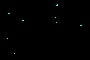

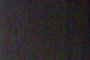

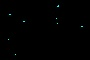

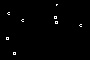

8
3100.8086991 -1 -0.000322496515277
三角形


/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/usr/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/usr/lib/python2.7/inspect.py", line 499, in getmodule
    os.path.realpath(f)] = module.__name__
  File "

IndexError: string index out of range

In [5]:
while True:
    if test_fps:
        time0 = time.time()
    cir_time, rect_time, tri_time = 0, 0, 0
    blue_time, green_time, red_time = 0, 0, 0
    real_pixel_list = []
    shape, color = -1, -1
    for k in range(10):
        frame = cam.read_img_ori()
        roi = frame[170:230, 350:440].copy()
        mask = np.zeros(roi.shape, roi.dtype)

        # 给明显的蓝绿红在mask上着色
        blue_pixel = 0
        green_pixel = 0
        red_pixel = 0
        color = -1
        for i in range(roi.shape[0]):
            for j in range(roi.shape[1]):
                if (roi.item(i, j, 0) - roi.item(i, j, 1) > 50) and (roi.item(i, j, 0) - roi.item(i, j, 2) > 50):
                    color = 0
                    blue_pixel += 1
                    mask[i, j] = [0, 255, 255]
                elif (roi.item(i, j, 1) - roi.item(i, j, 0) > 30) and (roi.item(i, j, 1) - roi.item(i, j, 2) > 30):
                    color = 1
                    green_pixel += 1
                    mask[i, j] = [255, 0, 255]
                elif (roi.item(i, j, 2) - roi.item(i, j, 1) > 30) and (roi.item(i, j, 2) - roi.item(i, j, 0) > 30):
                    color = 2
                    red_pixel += 1
                    mask[i, j] = [255, 255, 0]

        # 判断图像的颜色
        if blue_pixel > 100 or green_pixel > 100 or red_pixel > 100:
            if blue_pixel > green_pixel and blue_pixel > red_pixel:
                real_pixel = blue_pixel
                blue_time += 1
                real_pixel_list.append(blue_pixel)
            elif green_pixel > blue_pixel and green_pixel > red_pixel:
                real_pixel = green_pixel
                green_time += 1
                real_pixel_list.append(green_pixel)
            elif red_pixel > blue_pixel and red_pixel > green_pixel:
                real_pixel = red_pixel
                red_time += 1
                real_pixel_list.append(red_pixel)
            else:
                real_pixel = -1
        else:
            real_pixel = -1

        # 根据判断出的颜色去除mask中的其他颜色
        if color != -1:
            for i in range(mask.shape[0]):
                for j in range(mask.shape[1]):
                    if mask.item(i, j, color) != 0:
                        mask[i, j] = [0, 0, 0]
        if debug_flag:
            clear_output(wait=True)
            if blue_pixel > 100 or green_pixel > 100 or red_pixel > 100:
                if blue_pixel > green_pixel and blue_pixel > red_pixel:
                    print 'blue'
                elif green_pixel > blue_pixel and green_pixel > red_pixel:
                    print 'green'
                elif red_pixel > blue_pixel and red_pixel > green_pixel:
                    print 'red'
                else:
                    print 'unknown color'
            else:
                print 'unknown color'
            ps.CommonFunction.show_img_jupyter(mask)
            ps.CommonFunction.show_img_jupyter(roi)

        # 图像处理
        # 腐蚀膨胀
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (4, 4))
        dilate = cv.dilate(mask, kernel)
        erode = cv.erode(dilate, kernel)
        ps.CommonFunction.show_img_jupyter(erode)
        # 边缘检测
        canny = cv.Canny(mask, 120, 120 * 3)
        ps.CommonFunction.show_img_jupyter(canny)

        # 判断形状
        try:
            # 找圆
            circles = cv.HoughCircles(image=canny, method=cv.HOUGH_GRADIENT,
                                      dp=1, minDist=200, param1=50, param2=30,
                                      minRadius=5, maxRadius=25)
            circles = np.uint16(np.round(circles))
            for i in circles[0, :]:
                cv.circle(roi, (i[0], i[1]), i[2], (0, 0, 255), 2)
                print "circle:", i[2]
            cir_time += 1
        except:
            try:
                # 找轮廓
                _, contours, _ = cv.findContours(canny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
                print len(contours)
                sum = contours[0].copy()
                for contour in contours:
                    sum = np.vstack((sum, contour))
                cv.drawContours(roi, contours, -1, (0, 0, 255), 2)
                # 找外接矩形，比较面积判断是正方形还是三角形
                rect = cv.minAreaRect(sum)
                width, height = rect[1]
                box_pixel = width * height
                print box_pixel, real_pixel, real_pixel / box_pixel
                if real_pixel / box_pixel < 0.7:
                    print "三角形"
                    tri_time += 1
                else:
                    print "正方形"
                    rect_time += 1
                box = cv.boxPoints(rect)
                box = np.int0(box)
                cv.drawContours(roi, [box], 0, (255, 0, 0), 1)
            except:
                pass

    if (cir_time > tri_time) and (cir_time > rect_time):
        shape = 0
    elif (rect_time > cir_time) and (rect_time > tri_time):
        shape = 1
    elif (tri_time > rect_time) and (tri_time > cir_time):
        shape = 2

    if (blue_time > green_time) and (blue_time > red_time):
        color = 0
    elif (green_time > blue_time) and (green_time > red_time):
        color = 1
    elif (red_time > green_time) and (red_time > blue_time):
        color = 2

    real_pixel = int(np.average(real_pixel_list))

    ps.CommonFunction.show_img_jupyter(roi)
    send = [magicword_start, color, ord(','), shape, ord(','), real_pixel // 256, real_pixel % 256, magicword_end]
    ser.u_send_bytes(np.array(send))
    print send

    if test_fps:
        time1 = time.time()
        fps = 1 / (time1 - time0)
        print fps
    time.sleep(1)